# Emotion Detection

### Importing Libraries

In [1]:
import matplotlib.pyplot as plt
from glob import glob
import cv2
import random 
import os
%matplotlib inline
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense,Input,Dropout,Flatten,Conv2D
from tensorflow.keras.layers import BatchNormalization,Activation,MaxPooling2D
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint,ReduceLROnPlateau
from tensorflow.keras.utils import plot_model
from IPython.display import SVG,Image
import tensorflow as tf
print("TenserFlow Version: ",tf.__version__)

TenserFlow Version:  2.17.0


In [2]:
image=glob("train/**/**")

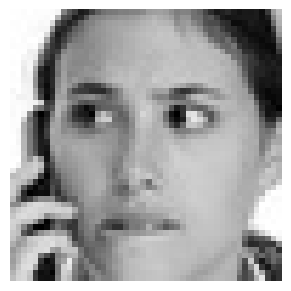

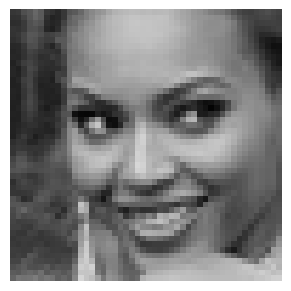

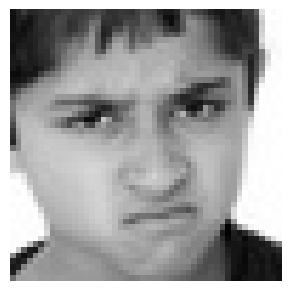

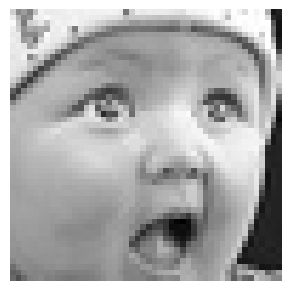

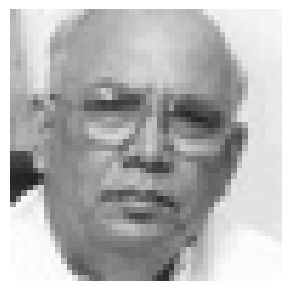

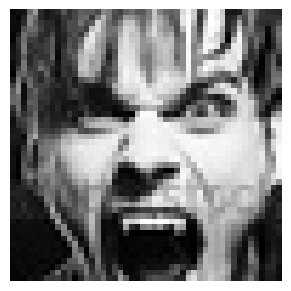

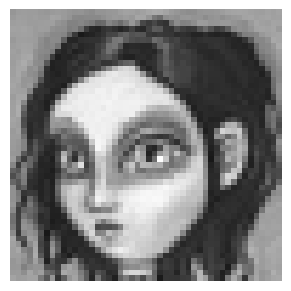

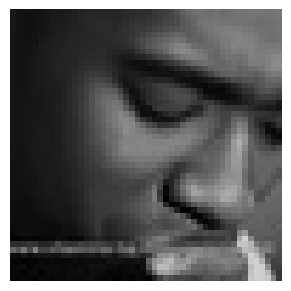

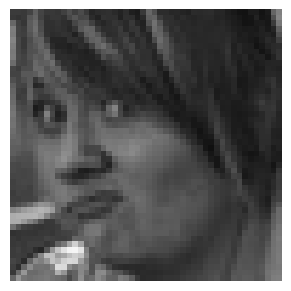

In [3]:
for i in range(9):
    img=random.choice(image)
    plt.figure(figsize=(12,12))
    plt.subplot(331+i)
    plt.imshow(cv2.imread(img));plt.axis('off')

### Preprocessing the data

In [4]:
img_size=48
batch_size=64
datagen_train=ImageDataGenerator()
train_generator=datagen_train.flow_from_directory("train/",target_size=(img_size,img_size),color_mode="grayscale",batch_size=batch_size,class_mode="categorical",shuffle=True)
datagen_validation=ImageDataGenerator()
validation_generator=datagen_train.flow_from_directory("test/",target_size=(img_size,img_size),color_mode="grayscale",batch_size=batch_size,class_mode="categorical",shuffle=True)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


### Defining Model

In [5]:
def convulution(input_tensor,filters,kernel_size):
    x=Conv2D(filters,kernel_size=kernel_size,padding='same')(input_tensor)
    x=BatchNormalization()(x)
    x=Activation('relu')(x)
    x=MaxPooling2D(pool_size=(2, 2))(x)
    x=Dropout(0.25)(x)
    return x
    

In [6]:
def Dense_f(input_tensor,nodes):
    x=Dense(nodes)(input_tensor)
    x=BatchNormalization()(x)
    x=Activation('relu')(x)
    x=Dropout(0.25)(x)
    return x

In [7]:
def model_fer(input_shape):
    inputs=Input(input_shape)
    conv_1=convulution(inputs,32,(3,3))
    conv_2=convulution(inputs,64,(5,5))
    conv_3=convulution(inputs,128,(3,3))
    flatten=Flatten()(conv_3)
    dense_1=Dense_f(flatten,256)
    output=Dense(7,activation="softmax")(dense_1)
    model=Model(inputs=[inputs],outputs=[output])
    model.compile(loss=['categorical_crossentropy'],optimizer='adam',metrics=['accuracy'])
    return model
    

In [8]:
model=model_fer((48,48,1))
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 48, 48, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 48, 48, 128)         │           1,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 48, 48, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 48, 48, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 24, 24, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 24, 24, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 73728)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │      18,874,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 7)                   │           1,799 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 18,879,239 (72.02 MB)

 Trainable params: 18,878,471 (72.02 MB)

 Non-trainable params: 768 (3.00 KB)

## Initializing the model

In [15]:
epochs=15
steps_per_epoch=train_generator.n//train_generator.batch_size
Validation_steps=validation_generator.n//validation_generator.batch_size
checkpoint=ModelCheckpoint("model.weights.h5",monitor='val_accuracy',save_weights_only=True,mode='max',verbose=1)
callbacks=[checkpoint]

## Training the model

In [16]:
history=model.fit(x=train_generator,
                  steps_per_epoch=steps_per_epoch,
                  epochs=epochs,
                  validation_data=validation_generator,
                  validation_steps=Validation_steps,
                  callbacks=callbacks)

Epoch 1/15
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step - accuracy: 0.5695 - loss: 1.1442
Epoch 1: saving model to model.weights.h5
448/448 ━━━━━━━━━━━━━━━━━━━━ 202s 451ms/step - accuracy: 0.5695 - loss: 1.1443 - val_accuracy: 0.3672 - val_loss: 1.6358
Epoch 2/15
  1/448 ━━━━━━━━━━━━━━━━━━━━ 3:21 450ms/step - accuracy: 0.5938 - loss: 1.0866
Epoch 2: saving model to model.weights.h5
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5938 - loss: 1.0866 - val_accuracy: 0.3000 - val_loss: 1.5459
Epoch 3/15
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step - accuracy: 0.6357 - loss: 0.9979
Epoch 3: saving model to model.weights.h5
448/448 ━━━━━━━━━━━━━━━━━━━━ 207s 461ms/step - accuracy: 0.6357 - loss: 0.9980 - val_accuracy: 0.4346 - val_loss: 1.4952
Epoch 4/15
  1/448 ━━━━━━━━━━━━━━━━━━━━ 3:13 433ms/step - accuracy: 0.4844 - loss: 1.2846
Epoch 4: saving model to model.weights.h5
448/448 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.4844 - loss: 1.2846 - val_accuracy: 0.4000 - val_loss: 1.5289


## Model Evaluation

In [17]:
model.evaluate(validation_generator)

113/113 ━━━━━━━━━━━━━━━━━━━━ 9s 80ms/step - accuracy: 0.4730 - loss: 1.7592


[1.7624472379684448, 0.46851491928100586]

## Plotting Loss

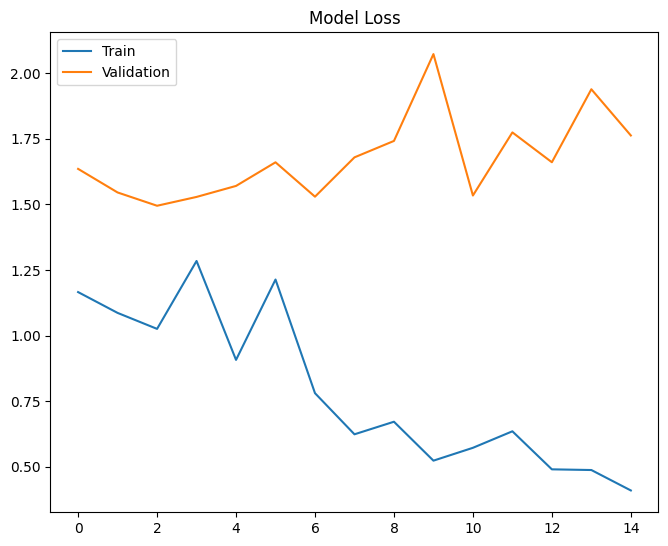

In [18]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Model Loss")
plt.legend(['Train','Validation'],loc='upper left')
plt.subplots_adjust(top=1.0,bottom=0.0,right=0.95,left=0.0,hspace=0.25,wspace=0.35)

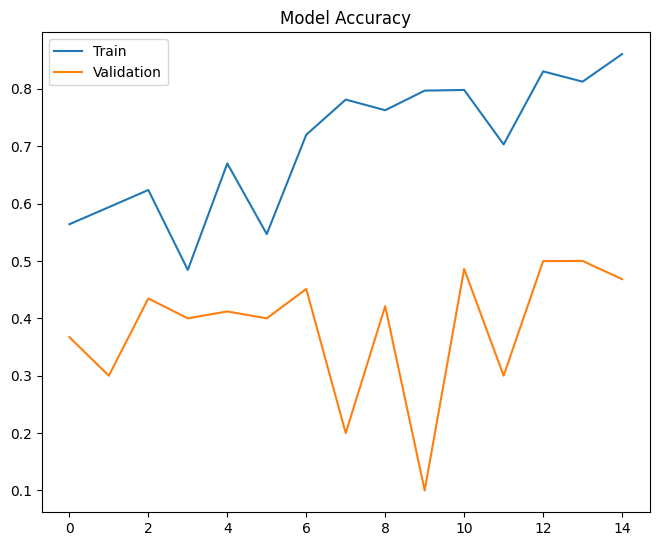

In [19]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("Model Accuracy")
plt.legend(['Train','Validation'],loc='upper left')
plt.subplots_adjust(top=1.0,bottom=0.0,right=0.95,left=0.0,hspace=0.25,wspace=0.35)

## Model Saving

In [21]:
model_json=model.to_json()
with open("model_a.json","w") as json_file:
    json_file.write(model_json)